# Regresión Lineal

In [66]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

In [5]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [8]:
#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=5, input_type='string')
#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])
#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())
#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])

In [80]:
df

,FECHA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA,0,1,2,3,4,MONTH
0,2020-01,58.0,11.519355,3.848387,23.580645,3.706452,12.183871,1013.903226,3.838710,0.09,-2.0,-1.0,4.0,0.0,1.0,1
1,2020-01,674.0,6.996774,1.354839,32.483871,0.916129,6.451613,945.961290,5.474194,0.00,0.0,-3.0,3.0,0.0,0.0,1
2,2020-01,81.0,11.664516,1.193548,22.000000,1.767742,7.741935,1013.180645,6.896774,0.00,0.0,-3.0,2.0,0.0,1.0,1
3,2020-01,21.0,12.487097,0.690323,53.967742,3.425806,9.629032,1020.690323,6.409677,0.00,1.0,-1.0,3.0,0.0,2.0,1
4,2020-01,513.0,5.445161,0.948387,54.516129,3.229032,10.045161,963.483871,3.254839,0.00,0.0,-1.0,5.0,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,2023-02,690.0,5.757143,0.028571,19.892857,3.935714,11.978571,940.478571,7.700000,40.03,0.0,-1.0,3.0,0.0,0.0,2
1972,2023-02,56.0,9.582143,1.014286,59.678571,2.817857,8.164286,1015.625000,6.250000,24.16,0.0,-2.0,2.0,0.0,2.0,2
1973,2023-02,846.0,4.242857,0.267857,13.107143,3.760714,9.750000,924.460714,7.260714,78.59,0.0,-1.0,3.0,0.0,2.0,2
1974,2023-02,715.0,5.128571,0.335714,20.071429,1.757143,8.932143,939.407143,6.792857,183.92,1.0,1.0,3.0,0.0,1.0,2


In [78]:
df = df.assign(MONTH = lambda x: (x['FECHA'].astype(str).str.slice(start=5).astype(int)))

In [92]:
df.dtypes

FECHA              period[M]
ALTITUD              float64
TEMP_MED             float64
PREC                 float64
DIR                  float64
VEL_MEDIA            float64
RACHA                float64
PRES_MIN             float64
SOL                  float64
TASA_INCIDENCIA      float64
0                    float64
1                    float64
2                    float64
3                    float64
4                    float64
MONTH                  int32
dtype: object

In [81]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # performin min-max scaling each continuous feature column to the range [0, 1]
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(df_train[selected_features])
# X_test = scaler.transform(df_test[selected_features])
# y_train = df_train['TASA_INCIDENCIA']

In [82]:
selected_features = ['MONTH', 'ALTITUD', 'TEMP_MED', 'PREC', 'DIR', 'VEL_MEDIA', 'RACHA', 'PRES_MIN', 'SOL', 0, 1, 2, 3, 4]

In [83]:
X_train = df_train[selected_features]
X_test = df_test[selected_features]
y_train = df_train['TASA_INCIDENCIA']

In [84]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [85]:
y_pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [86]:
y_pred

array([ 850.66655876,  183.96287402,  712.9402062 ,  531.27622465,
       1432.28331915,  447.508215  , 1333.87104467, 1086.85140355,
        636.06645058,  200.58038256,  234.723003  ,  875.08140207,
       -308.62127692, 2075.59168219, 1538.20066163,  583.69978082,
        699.43373334,  454.96643472,  744.3523817 ,  607.82564685,
       1442.3014134 , 1407.36918601,  -79.8039105 ,  892.50107356,
       1099.38954115,  998.76081753,  477.66914081,  -65.62510344,
        636.47181918,  254.75108473,   61.43184658,  614.76713544,
        585.99593995,  836.41657983, 1621.87923047,  602.44069492,
       1659.77196534, 1133.79633709,  882.14876   ,   60.96801616,
       1647.62243494, -132.35263222,  904.30930385,  580.55889927,
        487.59528771,  301.26265355,  478.07196304,  478.59714793,
        -56.51774099,  743.19616207,  846.88972573,  246.50253596,
       1257.65471898,  351.65317954,  -73.290984  ,  893.26232857,
       -315.92422749,  429.26696552,  672.78534756,  870.85550

In [87]:
y_pred_no_neg = y_pred.copy()
y_pred_no_neg[y_pred < 0] = 0
y_pred_no_neg

array([ 850.66655876,  183.96287402,  712.9402062 ,  531.27622465,
       1432.28331915,  447.508215  , 1333.87104467, 1086.85140355,
        636.06645058,  200.58038256,  234.723003  ,  875.08140207,
          0.        , 2075.59168219, 1538.20066163,  583.69978082,
        699.43373334,  454.96643472,  744.3523817 ,  607.82564685,
       1442.3014134 , 1407.36918601,    0.        ,  892.50107356,
       1099.38954115,  998.76081753,  477.66914081,    0.        ,
        636.47181918,  254.75108473,   61.43184658,  614.76713544,
        585.99593995,  836.41657983, 1621.87923047,  602.44069492,
       1659.77196534, 1133.79633709,  882.14876   ,   60.96801616,
       1647.62243494,    0.        ,  904.30930385,  580.55889927,
        487.59528771,  301.26265355,  478.07196304,  478.59714793,
          0.        ,  743.19616207,  846.88972573,  246.50253596,
       1257.65471898,  351.65317954,    0.        ,  893.26232857,
          0.        ,  429.26696552,  672.78534756,  870.85550

In [88]:
mae = mean_absolute_error(df_test['TASA_INCIDENCIA'], y_pred_no_neg)
print ('MAE', mae)

MAE 712.008953909516


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


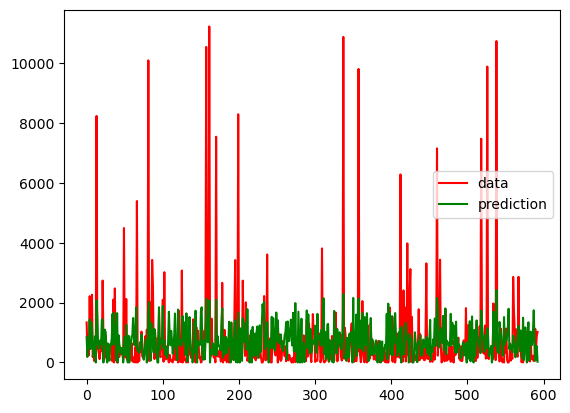

In [89]:
xx = np.stack(i for i in range(df_test['TASA_INCIDENCIA'].shape[0]))
plt.plot(xx, df_test['TASA_INCIDENCIA'], c='r', label='data')
plt.plot(xx, y_pred_no_neg, c='g', label='prediction')
plt.axis('tight')
plt.legend()

#plt.scatter(df_test['FECHA'], df_test['TASA_INCIDENCIA'])
#plt.plot(df_test['FECHA'], y_pred);

In [90]:
print(model.coef_)

[ 19.13754291  10.22020848 -85.609967     7.04211969   4.28049193
  43.30949061 -43.75778363  91.32049346 115.22635734 -50.64760728
 -32.07882094  16.83395879 107.31208111  17.60442599]


In [93]:
params = pd.Series(model.coef_, index=X_test.columns)
params

MONTH         19.137543
ALTITUD       10.220208
TEMP_MED     -85.609967
PREC           7.042120
DIR            4.280492
VEL_MEDIA     43.309491
RACHA        -43.757784
PRES_MIN      91.320493
SOL          115.226357
0            -50.647607
1            -32.078821
2             16.833959
3            107.312081
4             17.604426
dtype: float64

In [91]:
print(model.intercept_)
print("Coeficiente de determinación R^2:", model.score(np.array(X_train), y_train))

-91496.48112322962
Coeficiente de determinación R^2: 0.15330952718218738


In [67]:
print('Mean Squared Error: MSE', metrics.mean_squared_error(df_test['TASA_INCIDENCIA'], y_pred_no_neg))

Mean Squared Error: MSE 1586350.148443162


In [68]:
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(df_test['TASA_INCIDENCIA'], y_pred_no_neg)))

Root Mean Squared Error RMSE: 1259.5039295068364


# Mediante el Método de one hot encoding

In [ ]:
df_2 = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df_2['FECHA'] = pd.to_datetime(df_2.FECHA).dt.to_period('m')

In [ ]:
selected_features = ['ALTITUD','TEMP_MED','PREC','TEMP_MIN','TEMP_MAX','DIR','VEL_MEDIA','RACHA','PRES_MAX','PRES_MIN', 'SOL',('A CORUÑA',),('ALBACETE',),
('ALICANTE',), ('ALMERIA',),('ARABA/ALAVA',),('ASTURIAS',),('AVILA',), ('BADAJOZ',),('BARCELONA',), ('BIZKAIA',),('BURGOS',), ('CACERES',),('CADIZ',),
('CANTABRIA',),('CASTELLON',),('CEUTA',),('CIUDAD REAL',), ('CORDOBA',),('CUENCA',),('GIPUZKOA',),('GIRONA',), ('GRANADA',),('GUADALAJARA',),('HUELVA',),('HUESCA',),
('ILLES BALEARS',),('JAEN',),('LA RIOJA',),('LAS PALMAS',), ('LEON',),('LLEIDA',), ('LUGO',),('MADRID',),('MALAGA',),('MELILLA',),('MURCIA',),('NAVARRA',), ('OURENSE',),
('PALENCIA',),('PONTEVEDRA',),('SALAMANCA',), ('SEGOVIA',),('SEVILLA',),('SORIA',),('STA. CRUZ DE TENERIFE',),('TARRAGONA',),('TERUEL',),('TOLEDO',),('VALENCIA',),
('VALLADOLID',),('ZAMORA',),('ZARAGOZA',)]